In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, kstest
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## Section 1: Cumulant Calculation 

> *"For a Gaussian distribution, the first cumulant equals the distribution mean, second cumulant equals its variance, and all higher cumulants are zero. This must be noted as a key test for Gaussianity."*

In [29]:
def compute_cumulants(data, max_order=6):
    """
    Compute cumulants from raw moments.
    
    Inputs:
    data : array-like, Input data
    max_order : int, Maximum cumulant order to compute
        
    Output: dict : Cumulants {1: κ₁, 2: κ₂, ..., max_order: κ_max}
    """
    # Raw moments m_r = E[X^r]
    m = {}
    for r in range(1, max_order + 1):
        m[r] = np.mean(data**r)
    
    # Converting moments to cumulants
    k = {}
    
    k[1] = m[1]
    if 2 in m:
        k[2] = m[2] - m[1]**2
    if 3 in m:
        k[3] = m[3] - 3*m[2]*m[1] + 2*m[1]**3
    if 4 in m:
        k[4] = m[4] - 4*m[3]*m[1] - 3*m[2]**2 + 12*m[2]*m[1]**2 - 6*m[1]**4
    if 5 in m:
        k[5] = (m[5] - 5*m[4]*m[1] - 10*m[3]*m[2] + 20*m[3]*m[1]**2 
                + 30*m[2]**2*m[1] - 60*m[2]*m[1]**3 + 24*m[1]**5)
    if 6 in m:
        k[6] = (m[6] - 6*m[5]*m[1] - 15*m[4]*m[2] + 30*m[4]*m[1]**2
                - 10*m[3]**2 + 120*m[3]*m[2]*m[1] - 120*m[3]*m[1]**3
                + 30*m[2]**3 - 270*m[2]**2*m[1]**2 + 360*m[2]*m[1]**4
                - 120*m[1]**6)
    return k

# # Testing on a Gaussian distribution
# test_gaussian = np.random.randn(100_000)
# k_test = compute_cumulants(test_gaussian, max_order=4)
# print("Test on Gaussian N(0,1):")
# print(f"  K_1 (mean)     = {k_test[1]:.6f}  [should be ≈ 0]")
# print(f"  K_2 (variance) = {k_test[2]:.6f}  [should be ≈ 1]")
# print(f"  K_3 (skewness) = {k_test[3]:.6f}  [should be ≈ 0]")
# print(f"  K_4 (kurtosis) = {k_test[4]:.6f}  [should be ≈ 0]")

## Section 2: Normalized Sum Z_n

> *"Z_n = (S_n - nμ)/(sigma√n) such that the rescaled variable has zero mean and unit variance."*

This normalization prevents the distribution from spreading to infinity and allows us to study its **shape** independent of scale.

In [30]:
def generate_z_n(dist_func, n, n_trials=5000):
    
    # Estimate population parameters
    large_sample = dist_func(100_000)
    mu = np.mean(large_sample)
    sigma = np.std(large_sample, ddof=1)
    
    # Generate normalized sums
    z_n = np.zeros(n_trials)
    for i in range(n_trials):
        s_n = np.sum(dist_func(n))
        z_n[i] = (s_n - n*mu) / (sigma*np.sqrt(n))
    
    return z_n, mu, sigma

## Section 3: Five Non-Gaussian Test Distributions


> *"Gaussian distributions are 'universal attractors' of i.i.d. random variables"*

Testing with 6  different distributions:
1. Uniform(0,1)
2. Gamma(4,0.5)
3. Chi-squared (5)
4. Laplace (0,1)
5. Beta (0.5, 0.5)
6. Triangular (0,0.5,1)

In [31]:
# Test distributions
distributions = {
    'Uniform': {
        'func': lambda n: np.random.uniform(0, 1, n),
        'params': '(0,1)',
        'color': '#8B4513'
    },
    'Gamma': {
        'func': lambda n: np.random.gamma(4, 0.5, n),
        'params': '(4,0.5)',
        'color': '#FF6347'
    },
    'Chi-squared': {
        'func': lambda n: np.random.chisquare(5, n),
        'params': '(5)',
        'color': '#4169E1'
    },
    'Triangular': {
        'func': lambda n: np.random.triangular(0, 0.5, 1, n),
        'params': '(0,0.5,1)',
        'color': '#32CD32'
    },
    'Laplace': {
        'func': lambda n: np.random.laplace(0, 1.0, n),
        'params': '(0,1)',
        'color': "#252C20"
    },
    'Beta': {
        'func': lambda n: np.random.beta(0.5, 0.5, n),
        'params': '(0.5,0.5)',
        'color': '#9370DB'
    }
}

# Base cumulants
print("Base Distribution Cumulants:")
for name, info in distributions.items():
    samples = info['func'](100_000)
    k = compute_cumulants(samples, max_order=4)
    print(f"{name:22s}: K_3={k[3]:10.6f}, K_4={k[4]:10.6f}")
    info['base_k'] = k

print("\nAll have K_3 != 0 or K_4 != 0, so NONE are Gaussian!")
print("But all * will * converge to Gaussian as n increases...")

Base Distribution Cumulants:
Uniform               : K_3= -0.000021, K_4= -0.008299
Gamma                 : K_3=  1.004345, K_4=  1.485165
Chi-squared           : K_3= 39.642924, K_4=230.530675
Triangular            : K_3=  0.000102, K_4= -0.001025
Laplace               : K_3= -0.000508, K_4= 11.317563
Beta                  : K_3=  0.000160, K_4= -0.023412

All have K_3 != 0 or K_4 != 0, so NONE are Gaussian!
But all * will * converge to Gaussian as n increases...


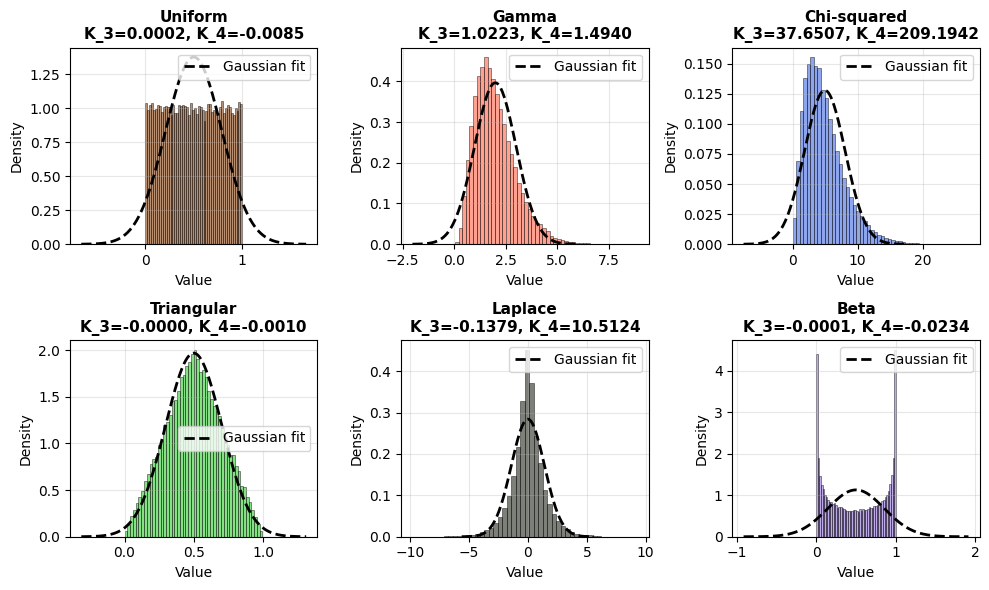

In [32]:
# Base samples and plot
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for idx, (name, info) in enumerate(distributions.items()):
    ax = axes[idx]
    
    # Generate samples
    samples = info['func'](50_000)
    ax.hist(samples, bins=50, density=True, alpha=0.6, color=info['color'], edgecolor='black', linewidth=0.5)
    
    # Gaussian for comparison
    mu = np.mean(samples)
    sigma = np.std(samples)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 200)
    ax.plot(x, norm.pdf(x, mu, sigma), 'k--', linewidth=2, label='Gaussian fit')
    
    # Compute cumulants
    k = compute_cumulants(samples, max_order=4)
    ax.set_title(f'{name}\nK_3={k[3]:.4f}, K_4={k[4]:.4f}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Section 4: Generate Z_n for Multiple n

> *"All higher cumulants tend to 0 as n increases!"*

In [ ]:
# Values of n to test
n_values = [1, 5, 10, 20, 50, 100, 200, 500, 1000]
n_trials = 100_000

print(f"Computing Z_n for n ∈ {n_values}")
print(f"Generating {n_trials} realizations per n")

# Store all results
results = {}

for dist_name, dist_info in distributions.items():
    print(f"\n{dist_name}")
    
    results[dist_name] = {
        'z_samples': {},
        'cumulants': {},
        'theoretical': {},
        'color': dist_info['color']
    }
    
    # Get population parameters
    base_samples = dist_info['func'](50000)
    mu = np.mean(base_samples)
    sigma = np.std(base_samples, ddof=1)
    base_k = compute_cumulants(base_samples, max_order=6)
    
    for n in n_values:
        # Generate Z_n
        z_n, _, _ = generate_z_n(dist_info['func'], n, n_trials)
        results[dist_name]['z_samples'][n] = z_n
        
        # Compute empirical cumulants
        emp_k = compute_cumulants(z_n, max_order=6)
        results[dist_name]['cumulants'][n] = emp_k
        
        # Compute theoretical cumulants: κᵣ(Z_n) = (kᵣ/sigmaʳ) × n^(1-r/2)
        theo_k = {1: 0.0, 2: 1.0}
        for r in [3, 4, 5, 6]:
            if r in base_k:
                theo_k[r] = (base_k[r] / sigma**r) * n**(1 - r/2)
        results[dist_name]['theoretical'][n] = theo_k
    
print("\nDistribution Sampling Complete.")

Computing Z_n for n ∈ [1, 5, 10, 20, 50, 100, 200, 500, 1000]
Generating 100000 realizations per n

Uniform             ... 
Gamma               ... 
Chi-squared         ... 
Triangular          ... 
Laplace             ... 
Beta                ... 
Distribution Sampling Complete.


## Convergence for all 6 distributions at 3 different n values

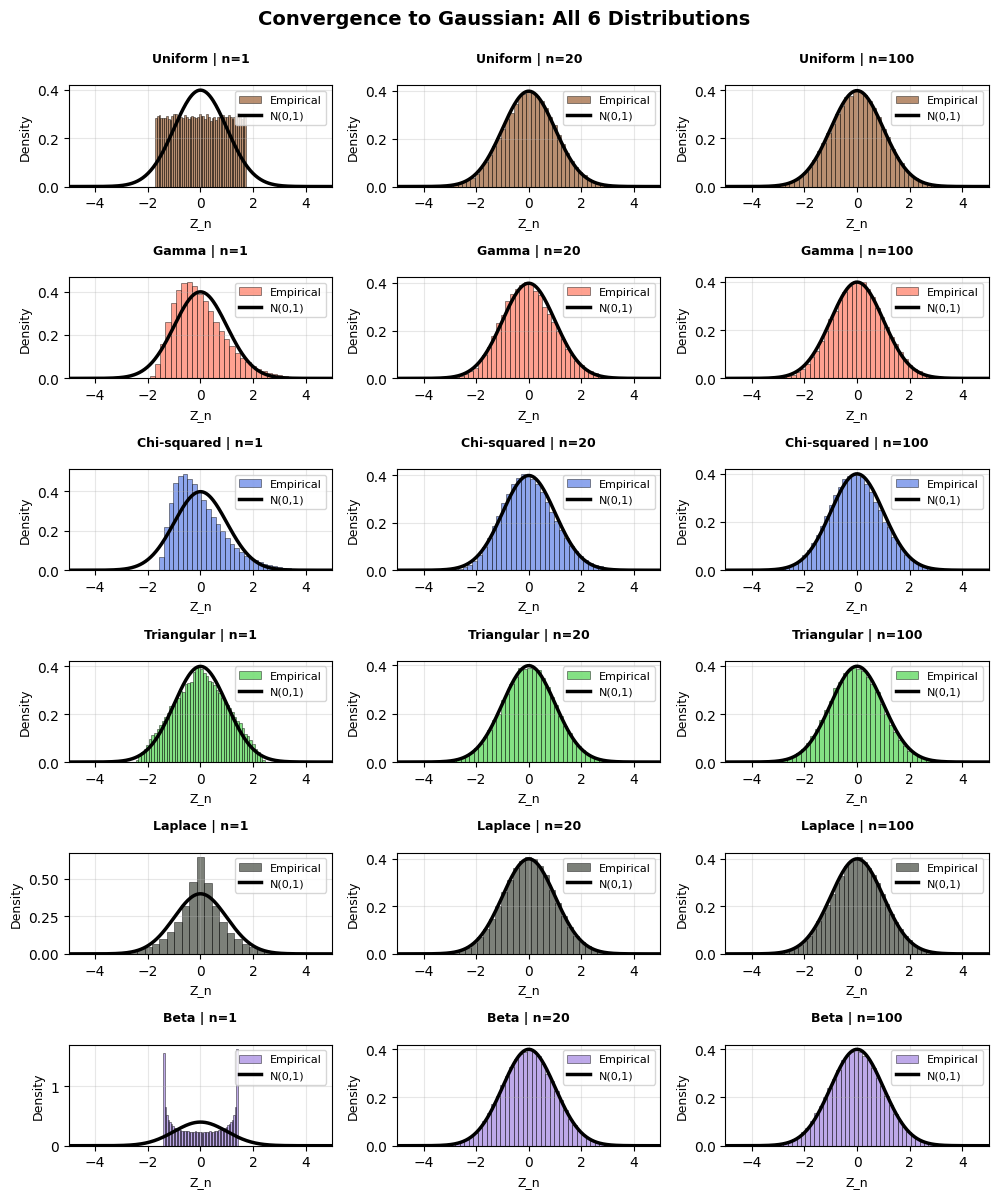

In [34]:
selected_n = [1, 20, 100]
dist_names_list = list(distributions.keys())

fig, axes = plt.subplots(6, 3, figsize=(10, 12))

for i, dist_name in enumerate(dist_names_list):
    for j, n in enumerate(selected_n):
        ax = axes[i, j]
        z_n = results[dist_name]['z_samples'][n]
        
        ax.hist(z_n, bins=50, density=True, alpha=0.6,
                color=results[dist_name]['color'], edgecolor='black', linewidth=0.5,
                label='Empirical')
        
        # Standard Gaussian
        x = np.linspace(-5, 5, 300)
        ax.plot(x, norm.pdf(x), 'k-', linewidth=2.5, label='N(0,1)')
        
        # Get cumulants
        emp_k = results[dist_name]['cumulants'][n]
        title = f'{dist_name} | n={n}\n'
        ax.set_title(title, fontsize=9, fontweight='bold')
        ax.set_xlabel('Z_n', fontsize=9)
        ax.set_ylabel('Density', fontsize=9)
        ax.set_xlim(-5, 5)
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(alpha=0.3)

plt.suptitle('Convergence to Gaussian: All 6 Distributions', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Cumulant decay for all distributions

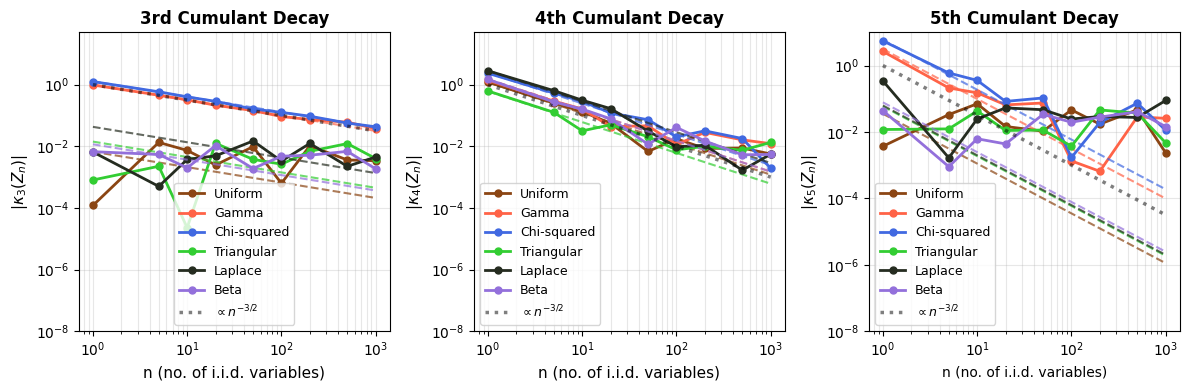

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# K_3 decay
ax = axes[0]
for dist_name in distributions.keys():
    k3_vals_emp = [abs(results[dist_name]['cumulants'][n][3]) for n in n_values]
    k3_vals_theo = [abs(results[dist_name]['theoretical'][n][3]) for n in n_values]
    
    color = results[dist_name]['color']
    ax.loglog(n_values, k3_vals_emp, 'o-', color=color, linewidth=2, markersize=5, label=dist_name)
    ax.loglog(n_values, k3_vals_theo, '--', color=color, linewidth=1.5, alpha=0.7)

ref_n = np.array(n_values)
ax.loglog(ref_n, 1.0 / np.sqrt(ref_n), 'k:', linewidth=2.5, label=r'$\propto n^{-3/2}$', alpha=0.5)
ax.set_ylim(1e-8, 5e1)
ax.set_xlabel('n (no. of i.i.d. variables)', fontsize=11)
ax.set_ylabel(r'$|\kappa_3(Z_n)|$', fontsize=11, fontweight='bold')
ax.set_title('3rd Cumulant Decay', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, which='both', alpha=0.3)

# K_4 decay
ax = axes[1]
for dist_name in distributions.keys():
    k4_vals_emp = [abs(results[dist_name]['cumulants'][n][4]) for n in n_values]
    k4_vals_theo = [abs(results[dist_name]['theoretical'][n][4]) for n in n_values]
    
    color = results[dist_name]['color']
    ax.loglog(n_values, k4_vals_emp, 'o-', color=color, linewidth=2, markersize=5, label=dist_name)
    ax.loglog(n_values, k4_vals_theo, '--', color=color, linewidth=1.5, alpha=0.7)

ax.loglog(ref_n, 1.0 / ref_n, 'k:', linewidth=2.5, label=r'$\propto n^{-3/2}$', alpha=0.5)
ax.set_ylim(1e-8, 5e1)
ax.set_xlabel('n (no. of i.i.d. variables)', fontsize=11)
ax.set_ylabel(r'$|\kappa_4(Z_n)|$', fontsize=11, fontweight='bold')
ax.set_title('4th Cumulant Decay', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, which='both', alpha=0.3)

# K_5 decay
ax = axes[2]
for dist_name in distributions.keys():
    k5_vals_emp = [abs(results[dist_name]['cumulants'][n][5]) for n in n_values]
    k5_vals_theo = [abs(results[dist_name]['theoretical'][n][5]) for n in n_values]
    
    color = results[dist_name]['color']
    ax.loglog(n_values, k5_vals_emp, 'o-', color=color, linewidth=2, markersize=5, label=dist_name)
    ax.loglog(n_values, k5_vals_theo, '--', color=color, linewidth=1.5, alpha=0.7)

ax.loglog(ref_n, 1.0 / (ref_n**1.5), 'k:', linewidth=2.5, label=r'$\propto n^{-3/2}$', alpha=0.5)
ax.set_ylim(1e-8, 1e1)
ax.set_xlabel('n (no. of i.i.d. variables)')
ax.set_ylabel(r'$|\kappa_5(Z_n)|$', fontsize=11)
ax.set_title('5th Cumulant Decay', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

## Section 5: Verification of Theoretical Formula

Let's verify that empirical cumulants match the theoretical prediction: **κᵣ(Z_n) = (kᵣ/sigmaʳ) × n^(1-r/2)**

In [38]:
print("VERIFICATION: Gamma(4,0.5)")
print("=" * 60)
print(f"\n{'n':<8} {'K_3(theory)':<14} {'K_3(empirical)':<14} {'K_4(theory)':<14} {'K_4(empirical)'}")
print("-" * 60)

for n in n_values:
    theo = results['Gamma']['theoretical'][n]
    emp = results['Gamma']['cumulants'][n]
    print(f"{n:<8} {theo[3]:<14.6f} {emp[3]:<14.6f} {theo[4]:<14.6f} {emp[4]:<14.6f}")

print("All higher cumulants K_r, r > 2 decay to zero. \nHigher cumulants decay faster...")

VERIFICATION: Gamma(4,0.5)

n        K_3(theory)    K_3(empirical) K_4(theory)    K_4(empirical)
------------------------------------------------------------
1        0.997067       0.976482       1.505166       1.392778      
5        0.445902       0.457363       0.301033       0.292155      
10       0.315300       0.321560       0.150517       0.162787      
20       0.222951       0.215068       0.075258       0.043690      
50       0.141007       0.144343       0.030103       0.046140      
100      0.099707       0.092522       0.015052       0.011377      
200      0.070503       0.073546       0.007526       0.028279      
500      0.044590       0.060675       0.003010       0.016163      
1000     0.031530       0.037435       0.001505       0.012159      
All higher cumulants K_r, r > 2 decay to zero. 
Higher cumulants decay faster...


## Section 6: Statistical Tests at n=1000

Verify that all distributions pass Gaussianity tests at large n.

In [40]:
n_test = 1000
print(f"STATISTICAL TESTS FOR GAUSSIANITY (at n={n_test})")
print()

for dist_name in distributions.keys():
    z_test = results[dist_name]['z_samples'][n_test]

    # Kolmogorov-Smirnov test
    z_standardized = (z_test - np.mean(z_test)) / np.std(z_test)
    ks_stat, ks_pval = kstest(z_standardized, 'norm')

    # Cumulant test
    k_test = results[dist_name]['cumulants'][n_test]
    sigma = np.sqrt(k_test[2])
    std_k3 = abs(k_test[3] / sigma**3) if sigma > 0 else 0
    std_k4 = abs(k_test[4] / sigma**4) if sigma > 0 else 0
    
    print(f"{dist_name}:")
    print(f"  KS test: statistic={ks_stat:.6f}, p-value={ks_pval:.6f} "
          f"[{'PASS' if ks_pval > 0.05 else 'FAIL'}]")
    print(f"  Cumulant test: |K_3/sigma^3|={std_k3:.6f}, |K_4/sigma^4|={std_k4:.6f} "
          f"[{'PASS' if std_k3 < 0.1 and std_k4 < 0.1 else 'FAIL'}]")

STATISTICAL TESTS FOR GAUSSIANITY (at n=1000)

Uniform:
  KS test: statistic=0.001601, p-value=0.959426 [PASS]
  Cumulant test: |K_3/sigma^3|=0.003397, |K_4/sigma^4|=0.005614 [PASS]
Gamma:
  KS test: statistic=0.004631, p-value=0.027344 [FAIL]
  Cumulant test: |K_3/sigma^3|=0.037693, |K_4/sigma^4|=0.012271 [PASS]
Chi-squared:
  KS test: statistic=0.003870, p-value=0.099743 [PASS]
  Cumulant test: |K_3/sigma^3|=0.043503, |K_4/sigma^4|=0.001967 [PASS]
Triangular:
  KS test: statistic=0.001451, p-value=0.984220 [PASS]
  Cumulant test: |K_3/sigma^3|=0.004040, |K_4/sigma^4|=0.013564 [PASS]
Laplace:
  KS test: statistic=0.002679, p-value=0.468877 [PASS]
  Cumulant test: |K_3/sigma^3|=0.004480, |K_4/sigma^4|=0.005502 [PASS]
Beta:
  KS test: statistic=0.001582, p-value=0.963422 [PASS]
  Cumulant test: |K_3/sigma^3|=0.001842, |K_4/sigma^4|=0.005425 [PASS]


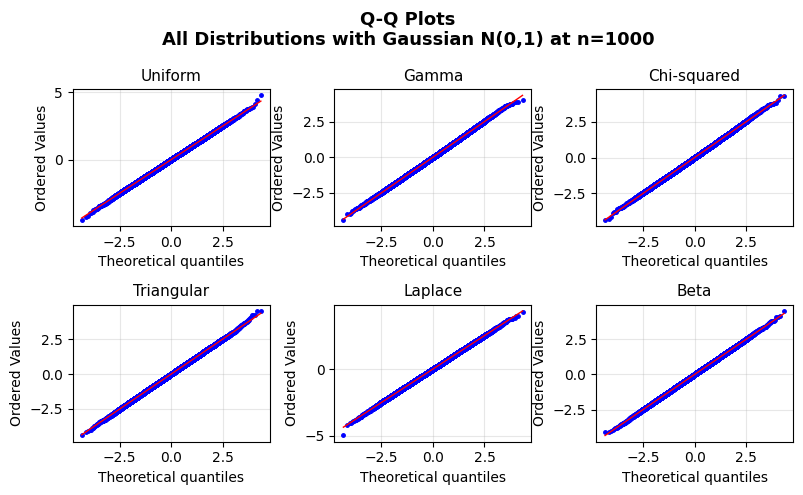

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.flatten()

for idx, (dist_name, ax) in enumerate(zip(distributions.keys(), axes)):
    z_test = results[dist_name]['z_samples'][n_test]
    z_standardized = (z_test - np.mean(z_test)) / np.std(z_test)
    
    # Q-Q plot
    stats.probplot(z_standardized, dist="norm", plot=ax)
    ax.get_lines()[0].set_markersize(2.5)
    ax.get_lines()[1].set_linewidth(1.0)
    ax.set_title(f'{dist_name}', fontsize=11)
    ax.grid(alpha=0.3)

plt.suptitle('Q-Q Plots\nAll Distributions with Gaussian N(0,1) at n=1000', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()